# ISC data preparation
- In this notebook, I clean the dataset retrieved from the ISC-EHB catalog. 
- This is similar to the code in other_areas, but decided to separate this as the core processes are different
- Run this with the proj1 environment

In [47]:
import numpy as np
import pandas as pd
import json, re, sys, math
import matplotlib.pyplot as plt
from obspy.core import UTCDateTime # this is a very convenient function!
import cartopy
from pathlib import Path
from datetime import datetime


import vis_pkg
import slab_data_mani

sys.path.append('seismo/src')
from stat_seismo import *

%matplotlib inline

In [48]:
""" Parameters here """
diff_thresh = 20 # megathrust interface threshold
out_suffix = "sum"

isc_fname = "/Users/jgra0019/Documents/codes/seismo/seismo/data/sum_isc_raw.csv"

isc_df = pd.read_csv(isc_fname, header = 'infer')


{
  "sedi_grd": "phd_data/sedi_thk/sum_sedi.nc",
  "sedi_xyz": "phd_data/sedi_thk/sum_sedi.xyz",
  "sedi_along": "codes/sediment_analysis/out/sedi_thk_al_tr/sum_sedi_thk.csv",
  "topo_grd": "phd_research/data/topography/sum_region.grd",
  "trench_full": "phd_data/trench/sum_full.txt",
  "trench_used": "phd_data/trench/sum_trench_st_anda.txt",
  "grid_dir_5": "phd_data/grids/sum/grid_5km/profile_dir",
  "grid_dir_10": "phd_data/grids/sum/grid_10km/profile_dir",
  "grid_dir_20": "phd_data/grids/sum/grid_20km/profile_dir",
  "grid_dir_30": "phd_data/grids/sum/grid_30km/profile_dir",
  "grid_dir_40": "phd_data/grids/sum/grid_40km/profile_dir",
  "grid_dir_50": "phd_data/grids/sum/grid_50km/profile_dir",
  "dep_grd": "phd_data/sum_slab/sum_slab2_dep_02.23.18.grd",
  "dep_xyz": "phd_data/sum_slab/sum_slab2_dep_02.23.18.xyz",
  "thk_grd": "phd_data/sum_slab/sum_slab2_thk_02.23.18.grd",
  "thk_xyz": "phd_data/sum_slab/sum_slab2_thk_02.23.18.xyz",
  "dip_grd": "phd_data/sum_slab/sum_slab2_dip_0

# A. Earthquake catalog preparation

In [49]:
print('Before dropping duplicate events: ')
print(isc_df.shape)

isc_df = isc_df.drop_duplicates(subset='EVENTID', keep = 'last') # keep last (probably updates)

print('After dropping duplicate events: ')
print(isc_df.shape)

Before dropping duplicate events: 
(19091, 12)
After dropping duplicate events: 
(19091, 12)


In [50]:
isc_df = isc_df[isc_df.DEPQUAL.isin(['L1', 'L2'])] # remove the events with large uncertainty
isc_df = isc_df.reset_index(drop=True)
print("Events left after dropping L3 depths.")
print(isc_df.shape)

Events left after dropping L3 depths.
(13130, 12)


In [51]:
# check to make sure that the dataset has enough time coverage
from obspy.core import UTCDateTime

isc_dummy = np.array(isc_df['DATE'] + ' ' + isc_df['TIME'])

isc_ev_time = []

for val in isc_dummy:
    isc_ev_time.append(UTCDateTime(val))
    
ref_date = isc_ev_time[0]

isc_ev_time = np.array(isc_ev_time)

date2 = []

for val in isc_ev_time:
    date2.append(val - ref_date)
    
date2 = np.array(date2)

Text(0.5, 0, 'Years')

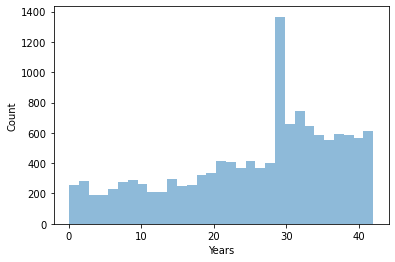

In [52]:
plt.hist(date2/31536000, bins = 'fd', alpha = 0.5)
plt.ylabel("Count")
plt.xlabel("Years")

## Find any row with nan magnitude, then delete them

In [53]:
row_has_NaN = isc_df['TYPE'].isnull()
isc_df[row_has_NaN]

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,DEPQUAL,AUTHOR.1,TYPE,MAG
109,615806325,ISC-EHB,1976-08-06,18:27:33.70,-7.725,116.770,29.6,NaN,L2,NaN,NaN,NaN
286,615808130,ISC-EHB,1977-07-22,06:00:57.53,6.809,94.345,10.8,NaN,L2,NaN,NaN,NaN


In [54]:
# delete the rows with null
isc_df = isc_df[~row_has_NaN]
isc_df.shape

(13128, 12)

# B. Extract the earthquakes that we want
- Try your best to remove events in the upper and in the downgoing plate


In [55]:
sh_thresh = -45 # threshold for indicating extent of the trench 
r_earth = 6371 # in km

# other data we need
slab_xyz = root_dir/conf["dep_xyz"]
slab_dip_xyz = root_dir/conf["dip_xyz"] 
slab_thk_xyz = root_dir/conf["thk_xyz"]
slab_unc_xyz = root_dir/conf["unc_xyz"]
trench_xy = root_dir/conf["trench_used"]
trench_xy_plt = root_dir/conf["trench_full"]

# read data
# need to be careful with the data
eq_df = isc_df # not a deep copy
eq_df = eq_df.reset_index(drop=True)
eq_df["LON"] = eq_df["LON"]%360 # convert to 0 to 360

trench_plt = pd.read_csv(trench_xy_plt, sep=',', header = None)

trench_df = pd.read_csv(trench_xy, sep=',', header = None)

# depth
slab_df = pd.read_csv(slab_xyz, header = None)
slab_df = slab_df[~slab_df[2].isnull()] # remove null values
slab_df = slab_df.reset_index(drop=True)

# dip
dip_df = pd.read_csv(slab_dip_xyz, header = None)
dip_df = dip_df[~dip_df[2].isnull()] # remove null values
dip_df = dip_df.reset_index(drop=True)

# thickness
thk_df = pd.read_csv(slab_thk_xyz, header = None)
thk_df = thk_df[~thk_df[2].isnull()] # remove null values
thk_df = thk_df.reset_index(drop=True)

# uncertainty
unc_df = pd.read_csv(slab_unc_xyz, header = None)
unc_df = unc_df[~unc_df[2].isnull()] # remove null values
unc_df = unc_df.reset_index(drop=True)

# assign column names
trench_plt.columns = ['LON', 'LAT']
trench_df.columns = ['LON', 'LAT']
slab_df.columns = ['LON', 'LAT', 'DEPTH']
dip_df.columns = ['LON', 'LAT', 'DIP']
unc_df.columns = ['LON', 'LAT', 'UNC']  
thk_df.columns = ['LON', 'LAT', 'THK'] 

# adjust depth - this is needed for processing
print("Depth before processing: ", slab_df['DEPTH'].min(), slab_df['DEPTH'].max())
slab_df['DEPTH'] = r_earth + slab_df['DEPTH']
eq_df['DEPTH'] = r_earth - eq_df['DEPTH']
print("Depth after processing: ", slab_df['DEPTH'].min(), slab_df['DEPTH'].max())

Depth before processing:  -673.276428223 -3.14684033394
Depth after processing:  5697.723571777 6367.85315966606


## Data before we continue processing

/Users/jgra0019/opt/anaconda3/envs/proj1/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj1/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


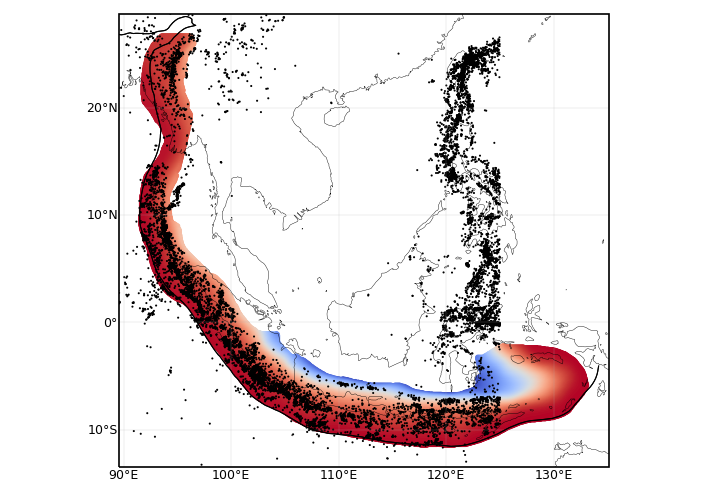

In [56]:
fig, m = vis_pkg.make_heatmap(slab_df['LON'], slab_df['LAT'], slab_df['DEPTH'], title = None,
                               cmap = plt.cm.coolwarm, vmin = None, vmax = None, mrkr_sz=1, is_alu = is_alu, is_ker = is_ker, 
                               norm = None, topo = None, extent= None, depth = None, 
                               trench_df = trench_plt, trench_fname = None, trench_arr_sz = None, dpi = 150)

#plot events
m.scatter(eq_df['LON'], eq_df['LAT'], s = 1, c = 'k', edgecolor = 'none', transform=cartopy.crs.PlateCarree())

m.plot(trench_plt['LON'], trench_plt['LAT'], '-', c = 'k', linewidth = 0.5)

In [57]:
# operate on the slab dataset first - add lower layer of slab 2.0 
# Do this if there are inequalities in the number of elements in the slab morphology dataset

size_list = [slab_df.shape[0], dip_df.shape[0], thk_df.shape[0], unc_df.shape[0]]

if size_list.count(size_list[0]) != len(size_list): # not all dataframes have the same number of elements
    
    print('Not all slab data have the same dimensions')
    
    thk_arr = []
    unc_arr = []
    dip_arr = []

    for idx, row in slab_df.iterrows():

        lon = row['LON']
        lat = row['LAT']

        thk_val = thk_df[(thk_df['LON'] == lon) & (thk_df['LAT'] == lat)]
        unc_val = unc_df[(unc_df['LON'] == lon) & (unc_df['LAT'] == lat)]
        dip_val = dip_df[(dip_df['LON'] == lon) & (dip_df['LAT'] == lat)]

        thk_arr.append(float(thk_val['THK']))
        unc_arr.append(float(unc_val['UNC']))
        dip_arr.append(float(dip_val['DIP']))

    thk_arr = np.array(thk_arr)
    unc_arr = np.array(unc_arr)
    dip_arr = np.array(dip_arr)
    
    slab_df['LW_DEPTH'] = slab_df['DEPTH'] - thk_arr
    slab_df['UNC'] = unc_arr
    slab_df['DIP'] = dip_arr
else:
    slab_df['LW_DEPTH'] = slab_df['DEPTH'] - thk_df['THK']
    slab_df['UNC'] = unc_df['UNC']
    slab_df['DIP'] = dip_df['DIP']
    

Not all slab data have the same dimensions


In [58]:
# earthquake data set
print('Earthquake dataset:')
print('LON:', eq_df['LON'].min(), eq_df['LON'].max())
print('LAT:', eq_df['LAT'].min(), eq_df['LAT'].max())

print('Slab dataset:')
print('LON:', slab_df['LON'].min(), slab_df['LON'].max())
print('LAT:', slab_df['LAT'].min(), slab_df['LAT'].max())

Earthquake dataset:
LON: 85.163 125.0
LAT: -16.617 29.988
Slab dataset:
LON: 91.55 133.1
LAT: -11.45 26.7


In [59]:
# Separate the earthquakes with lon-lat in the vicinity of the slab data

#mani = slab_data_mani.SlabManipulator(slab_xyz, trench_xy, r_earth)
mani = slab_data_mani.SlabManipulator(r_earth)
mani.read_slab(slab_xyz)

# will this have problems if range of lon are different?
lon_min = min(eq_df['LON'].min(), slab_df['LON'].min())
lon_max = max(eq_df['LON'].max(), slab_df['LON'].max())
lat_min = min(eq_df['LAT'].min(), slab_df['LAT'].min())
lat_max = max(eq_df['LAT'].max(), slab_df['LAT'].max())

mani.get_slab_border(lon_min, lon_max, lat_min, lat_max) # get the slab location mask

eq_colrow = mani._lonlat_to_colrow(np.asarray(eq_df['LON']), np.asarray(eq_df['LAT']))

mani.border_img = mani.border_img == 255

In [60]:
# see which earthquakes are above the slab
col = eq_colrow[:, 0]
row = eq_colrow[:, 1]
above_slab = mani.border_img[row, col]

eq_lonlat_in = eq_df[above_slab]
eq_lonlat_out = eq_df[~above_slab]

eq_lonlat_in = eq_lonlat_in.reset_index(drop=True)
eq_lonlat_out = eq_lonlat_out.reset_index(drop=True)

/Users/jgra0019/opt/anaconda3/envs/proj1/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj1/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


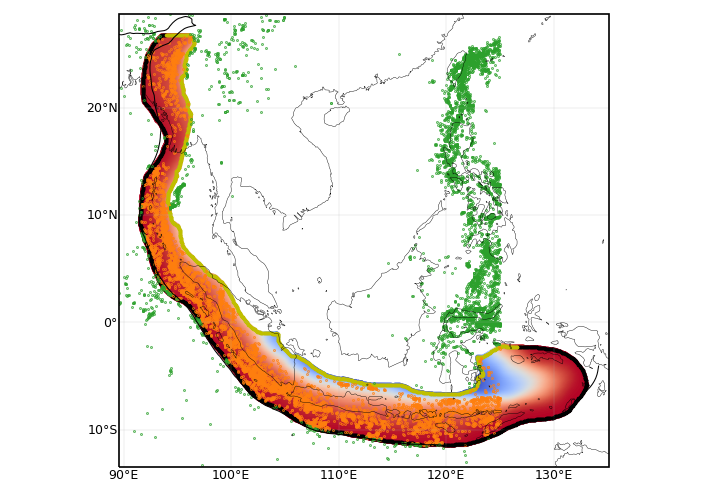

In [61]:
# plot results of first classification

fig, m = vis_pkg.make_heatmap(slab_df['LON'], slab_df['LAT'], slab_df['DEPTH'], title = None,
                               cmap = plt.cm.coolwarm, vmin = None, vmax = None, mrkr_sz=1, is_alu = is_alu, is_ker = is_ker, 
                               norm = None, topo = None, extent= None, depth = None, 
                               trench_df = trench_plt, trench_fname = None, trench_arr_sz = None, dpi = 150)

m.scatter(mani.x_bndry[mani.z_bndry >= sh_thresh], mani.y_bndry[mani.z_bndry >= sh_thresh], s = 0.5, marker = 'o', c = 'k', transform=cartopy.crs.PlateCarree())
m.scatter(mani.x_bndry[mani.z_bndry < sh_thresh], mani.y_bndry[mani.z_bndry < sh_thresh], s = 0.5, marker = 'o', c = 'y', transform=cartopy.crs.PlateCarree())
m.scatter(eq_lonlat_in['LON'], eq_lonlat_in['LAT'], s = 0.1, marker = 'o', c = 'C1', transform=cartopy.crs.PlateCarree())
m.scatter(eq_lonlat_out['LON'], eq_lonlat_out['LAT'], s = 0.1, marker = 'o', c = 'C2', transform=cartopy.crs.PlateCarree())


In [62]:
# filter earthquake events with lonlat coinciding with the lonlat of the slab 

mthrust_idx1 = []
downgoing_idx = []
upper_idx = []

mthrust_dip = []
dgoing_dip = []

mthrust_depth = r_earth - 70 # deepest megathrust event is ~70 km

# filter the earthquakes inside the lonlat of the slab
for i, eq_ev in eq_lonlat_in.iterrows():
    
    val = (eq_ev['LON'] - slab_df['LON'])**2 + (eq_ev['LAT'] - slab_df['LAT'])**2
    val = np.sqrt(val)
    idx = np.where(val == val.min())[0][0]
    candidate = slab_df.iloc[idx]
       
    # technically not the depth, but value in r-coord
    min_up_r = candidate['DEPTH'] - candidate['UNC']
    max_up_r = candidate['DEPTH'] + candidate['UNC']
    min_lw_r = candidate['LW_DEPTH'] - candidate['UNC']
    max_lw_r = candidate['LW_DEPTH'] + candidate['UNC']
         
    if eq_ev['DEPTH'] >= mthrust_depth: # either upper, megathrust
        if np.abs(eq_ev['DEPTH'] - candidate['DEPTH']) <= diff_thresh: # within threshold
            mthrust_idx1.append(i)
            mthrust_dip.append(candidate['DIP'])
        else:
            upper_idx.append(i)
    elif max_up_r <= eq_ev['DEPTH']: # event is shallower than slab depth + uncertainty
        upper_idx.append(i)
    elif eq_ev['DEPTH'] <= min_up_r: # event is deeper than slab depth - uncertainty
        downgoing_idx.append(i)
        dgoing_dip.append(candidate['DIP'])
    else: # tie-breaker
        if np.abs(eq_ev['DEPTH'] - min_up_r) < np.abs(eq_ev['DEPTH'] - max_up_r): # closer to downgoing
            downgoing_idx.append(i)
            dgoing_dip.append(candidate['DIP'])
        else:
            upper_idx.append(i)

    
mthrust_df1 = eq_lonlat_in.loc[mthrust_idx1]
downgoing_df = eq_lonlat_in.loc[downgoing_idx]
upper_df = eq_lonlat_in.loc[upper_idx]

upper_df['SLAB_DIP'] = 0
mthrust_df1['SLAB_DIP'] = np.array(mthrust_dip)
downgoing_df['SLAB_DIP'] = np.array(dgoing_dip)

In [63]:
# filter earthquake events with lonlat outside lonlat of the slab 
# relies on results of boundary computation - override this one for the megathrust
# IMPT NOTE: these earthquakes are still not over the slab though

# mthrust events in here - additional events not inside the boundary 
mthrust_idx1 = []
mthrust_dip = []

# assign dip to these events
eq_lonlat_out['SLAB_DIP'] = 0

downgoing_idx = []
upper_idx = []

dg_lon = mani.x_bndry[mani.z_bndry >= sh_thresh]
dg_lat = mani.y_bndry[mani.z_bndry >= sh_thresh]
up_lon = mani.x_bndry[mani.z_bndry < sh_thresh]
up_lat = mani.y_bndry[mani.z_bndry < sh_thresh]

# filter the earthquakes outside the lonlat of the slab
for i, eq_ev in eq_lonlat_out.iterrows():
        
    val_dg = np.sqrt((eq_ev['LON'] - dg_lon)**2 + (eq_ev['LAT'] - dg_lat)**2)
    val_up = np.sqrt((eq_ev['LON'] - up_lon)**2 + (eq_ev['LAT'] - up_lat)**2)
         
    if val_dg.min() < val_up.min(): # closer to downgoing plate
        downgoing_idx.append(i)
    else:
        upper_idx.append(i)
            
mthrust_df2 = eq_lonlat_out.loc[mthrust_idx1]
mthrust_df2['SLAB_DIP'] = np.array(mthrust_dip)

add_upper_df = eq_lonlat_out.loc[upper_idx]
add_down_df = eq_lonlat_out.loc[downgoing_idx]

In [64]:
# mthrust_df = pd.concat([mthrust_df1, mthrust_df2], axis = 0)
# downgoing_df = pd.concat([downgoing_df, add_down_df], axis = 0)
# upper_df = pd.concat([upper_df, add_upper_df], axis = 0)

mthrust_df = mthrust_df1 # not a copy, for now work on events coinciding with slab data

In [65]:
# remove additional events
mthrust_df = mthrust_df[~((mthrust_df['LAT'] >= -1.5) & (mthrust_df['LON'] >= 110))]
mthrust_df = mthrust_df[~((mthrust_df['LAT'] >= 10) & (mthrust_df['LON'] >= 97))]

downgoing_df = downgoing_df[~((downgoing_df['LAT'] >= -1.5) & (downgoing_df['LON'] >= 110))]
downgoing_df = downgoing_df[~((downgoing_df['LAT'] >= 10) & (downgoing_df['LON'] >= 97))]

upper_df = upper_df[~((upper_df['LAT'] >= -1.5) & (upper_df['LON'] >= 110))]
upper_df = upper_df[~((upper_df['LAT'] >= 10) & (upper_df['LON'] >= 97))]

In [66]:
mthrust_df = mthrust_df.reset_index(drop=True)
downgoing_df = downgoing_df.reset_index(drop=True)
upper_df = upper_df.reset_index(drop=True)

In [67]:
# concatenate events in downgoing and megathrust
final_df = pd.concat([mthrust_df, downgoing_df], axis = 0)
final_df.sort_values(by = "MAG", ascending = False, inplace = True)
final_df = final_df.reset_index(drop=True)

/Users/jgra0019/opt/anaconda3/envs/proj1/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj1/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(5559, 13)

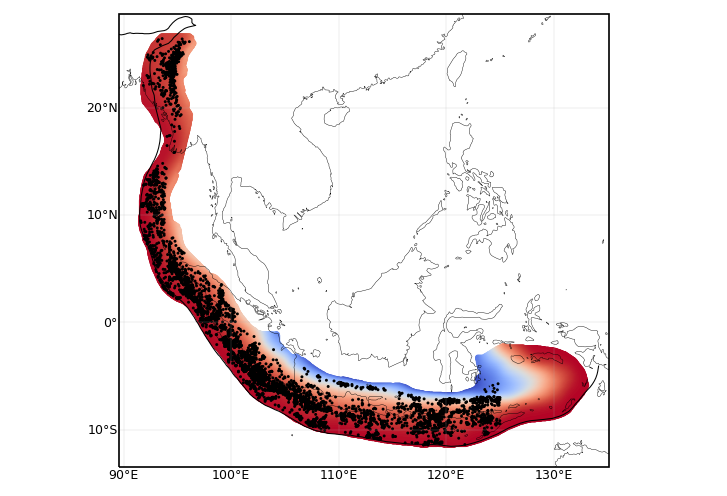

In [68]:
# plot the results of classification

fig, m = vis_pkg.make_heatmap(slab_df['LON'], slab_df['LAT'], slab_df['DEPTH'], title = None,
                               cmap = plt.cm.coolwarm, vmin = None, vmax = None, mrkr_sz=1, is_alu = is_alu, is_ker = is_ker,
                               norm = None, topo = None, extent= None, depth = None, 
                               trench_df = trench_plt, trench_fname = None, trench_arr_sz = None, dpi = 150)

#m.scatter(mani.x_bndry, mani.y_bndry, s = 0.5, edgecolor = 'none', marker = 'o', c = 'k', transform=cartopy.crs.PlateCarree())
m.scatter(final_df['LON'], final_df['LAT'], s = 2, edgecolor = 'none', marker = 'o', c = 'k', transform=cartopy.crs.PlateCarree(), label = 'Final catalogue')
final_df.shape

In [94]:
# calculate positions in cartesian coordinate system - km 
final_df['LON_RAD'] = np.deg2rad(final_df['LON'])
final_df['LAT_RAD'] = np.deg2rad(final_df['LAT'])

# cartesian position of events
final_df['X'] = (final_df['DEPTH'])*np.cos(final_df['LON_RAD'])*np.sin(0.5*np.pi - final_df['LAT_RAD'])
final_df['Y'] = (final_df['DEPTH'])*np.sin(final_df['LON_RAD'])*np.sin(0.5*np.pi - final_df['LAT_RAD'])
final_df['Z'] = (final_df['DEPTH'])*np.cos(0.5*np.pi - final_df['LAT_RAD'])

In [70]:
# create dataframe with format for nnd
# year, month, day, hour, minute, seconde, time, latitute, longitude, depth, magnitude

thresh_ev_time = "2004-12-26 00:58:53"
thresh_dt = datetime.strptime(thresh_ev_time, '%Y-%m-%d %H:%M:%S')
days_since_ref_thresh = (UTCDateTime(thresh_dt) - ref_date)/86400

year = []
month = []
day = []
hour = []
minute = []
second = []
time_since_ref = []

for idx, row in final_df.iterrows():
    datestring = row["DATE"] + " " + row["TIME"]
    try:
        dt = datetime.strptime(datestring, '%Y-%m-%d %H:%M:%S.%f')
    except:
        dt = datetime.strptime(datestring, '%Y-%m-%d %H:%M:%S')

    year.append(dt.year)
    month.append(dt.month)
    day.append(dt.day)
    hour.append(dt.hour)
    minute.append(dt.minute)
    second.append(dt.second)

    time_since_ref.append(UTCDateTime(dt) - ref_date)


In [71]:
to_save_df = {
    "year" : year,
    "month": month,
    "day": day,
    "hour": hour,
    "minute": minute,
    "seconde": second,
    "time": time_since_ref,
    "x_pos": list(final_df["X"]),
    "y_pos": list(final_df["Y"]),
    "z_pos": list(final_df["Z"]), 
    "magnitude": list(final_df["MAG"]),
    "longitude": list(final_df["LON"]),
    "latitude": list(final_df["LAT"]), # replace with x, y, z positions
    "depth": list(final_df["DEPTH"]),          
}
to_save_df = pd.DataFrame(to_save_df) 

# additional preprocessing steps
to_save_df["time"] = to_save_df["time"]/86400 # convert to days just to make numbers smaller
st_time = to_save_df["time"].min()
to_save_df["time"] = to_save_df["time"] - st_time
to_save_df.sort_values(by = "time", ascending = True, inplace = True)
to_save_df = to_save_df.reset_index(drop = True)

prior_2004_df = to_save_df[to_save_df["time"] < days_since_ref_thresh]
prior_2004_df = prior_2004_df.reset_index(drop = True)


# C. Calculate magnitude of completion for the two dataframes

In [72]:
# some parameters here
mbin = 0.1
num_runs = 300 # bootstrapping to get some spread

## C.1. Entire catalogue 

Complete catalogue: 
cut-off magnitude:  4.8475
cut-off error:  0.0837779804006
Estimated b-value:  1.18414067252
b-value error:  0.0217539172735


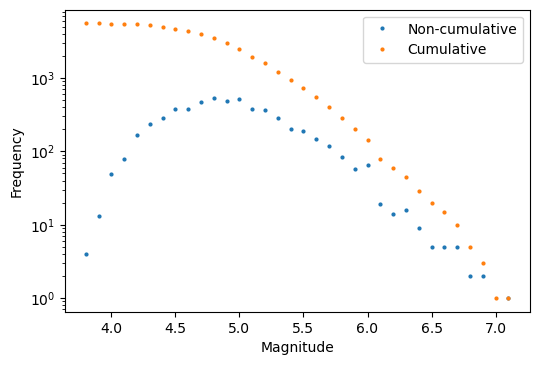

In [73]:

# run the function
m_cut_arr = np.zeros(num_runs)
num_ev = to_save_df["magnitude"].shape[0]

for i in np.arange(num_runs):
    mw_sample = to_save_df["magnitude"].sample(num_ev, replace = True)
    m_cut = get_max_curv(mw_sample)
    if len(m_cut > 0): # happens sometimes
        m_cut = m_cut.mean()
    m_cut_arr[i] = m_cut


m_cut = m_cut_arr.mean()
m_cut_err = m_cut_arr.std()

print("Complete catalogue: ")
print("cut-off magnitude: ", m_cut)
print("cut-off error: ", m_cut_err)

# calculate b-value using maximum likelihood (Aki 1965)
# another way of computing b
ev_above_cut = to_save_df[to_save_df['magnitude'] > m_cut]
diff_mag = (ev_above_cut["magnitude"] - m_cut - mbin/2)
b_est2 = 1/diff_mag.mean()
b_est2 = b_est2/np.log(10)
b_err2 = b_est2/np.sqrt(ev_above_cut.shape[0])

print("Estimated b-value: ", b_est2)
print("b-value error: ", b_err2)

# look at the hist for the entire catalog
m_vals, cum_mag, non_cum_mag = get_freq_mag_dist(to_save_df["magnitude"], mag_bin = 0.1)

fig, ax = plt.subplots(dpi = 100)
ax.plot(m_vals, non_cum_mag, 'o', markersize = 2, label = "Non-cumulative")
ax.plot(m_vals, cum_mag, 'o', markersize = 2, label = "Cumulative")
ax.set_xlabel("Magnitude")
ax.set_ylabel("Frequency")
ax.set_yscale("log")
ax.legend()


## C.2. Catalogue prior to the 2004 Sumatra event

Prior to December 26, 2004 catalogue: 
cut-off magnitude:  4.95283333333
cut-off error:  0.0771382236998
Estimated b-value:  1.32244591998
b-value error:  0.0364129213675


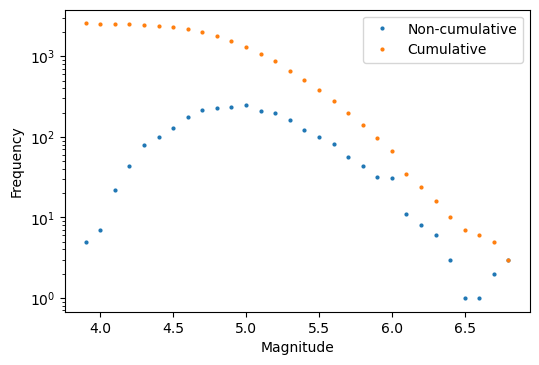

In [74]:

# run the function
m_cut_arr = np.zeros(num_runs)
num_ev = prior_2004_df["magnitude"].shape[0]

for i in np.arange(num_runs):
    mw_sample = prior_2004_df["magnitude"].sample(num_ev, replace = True)
    m_cut = get_max_curv(mw_sample)
    if len(m_cut > 0): # happens sometimes
        m_cut = m_cut.mean()
    m_cut_arr[i] = m_cut


m_cut = m_cut_arr.mean()
m_cut_err = m_cut_arr.std()

print("Prior to December 26, 2004 catalogue: ")
print("cut-off magnitude: ", m_cut)
print("cut-off error: ", m_cut_err)

# calculate b-value using maximum likelihood (Aki 1965)
# another way of computing b
ev_above_cut = prior_2004_df[prior_2004_df['magnitude'] > m_cut]
diff_mag = (ev_above_cut["magnitude"] - m_cut - mbin/2)
b_est2 = 1/diff_mag.mean()
b_est2 = b_est2/np.log(10)
b_err2 = b_est2/np.sqrt(ev_above_cut.shape[0])

print("Estimated b-value: ", b_est2)
print("b-value error: ", b_err2)

# look at the hist for the entire catalog
m_vals, cum_mag, non_cum_mag = get_freq_mag_dist(prior_2004_df["magnitude"], mag_bin = 0.1)

fig, ax = plt.subplots(dpi = 100)
ax.plot(m_vals, non_cum_mag, 'o', markersize = 2, label = "Non-cumulative")
ax.plot(m_vals, cum_mag, 'o', markersize = 2, label = "Cumulative")
ax.set_xlabel("Magnitude")
ax.set_ylabel("Frequency")
ax.set_yscale("log")
ax.legend()

# D. Calculate the fractal dimension according to Kagan GJI 2007
- Not yet done

In [75]:

num_ev = len(to_save_df)
pair_dist = -1*np.ones([num_ev, num_ev])

for i in range(num_ev):
    if i != num_ev - 1:
        pt1 = to_save_df.loc[i]
        other_pt = to_save_df.loc[i + 1:]
        pair_dist[i, i+1:] = np.sqrt((pt1["x_pos"] - other_pt["x_pos"])**2 +
                                      (pt1["y_pos"]- other_pt["y_pos"])**2 + 
                                      (pt1["z_pos"]- other_pt["z_pos"])**2)

all_dist = pair_dist[pair_dist > -1]

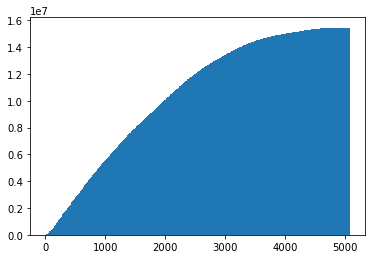

In [76]:
hist = plt.hist(all_dist, bins = 'fd', cumulative = True)
pair_count = hist[0]
pair_dist = hist[1]
pair_dist = (pair_dist[1:] + pair_dist[:-1])/2
#pair_count_norm = pair_count/pair_dist

In [77]:
np.polyfit(np.log10(pair_dist[pair_dist < 1e3]), np.log10(pair_count[pair_dist < 1e3]), 1)

array([ 1.21142332,  3.15688985])

[]

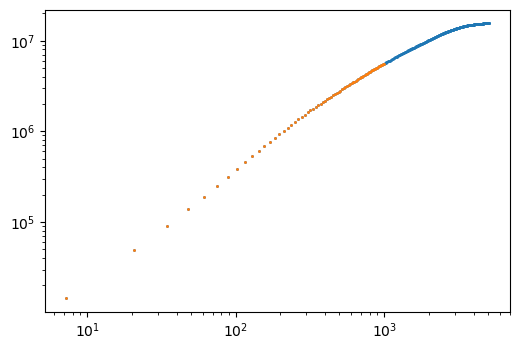

In [78]:
fig, ax = plt.subplots(dpi = 100)
ax.plot(pair_dist, pair_count, 'o', markersize = 1)
ax.plot(pair_dist[pair_dist < 1e3], pair_count[pair_dist < 1e3], 'o', markersize = 1)
ax.loglog()

In [79]:
# All events
out_fname = Path("/Users/jgra0019/Documents/codes/seismo/seismo/data")/(out_suffix + "_" + str(diff_thresh) + "_all.csv")
print(out_fname)
to_save_df.to_csv(out_fname, header = True, index = False)

/Users/jgra0019/Documents/codes/seismo/seismo/data/sum_20_all.csv


In [80]:
# Prior to 2004 event
out_fname = Path("/Users/jgra0019/Documents/codes/seismo/seismo/data")/(out_suffix + "_" + str(diff_thresh) + "_prior_2004.csv")
print(out_fname)
prior_2004_df.to_csv(out_fname, header = True, index = False)

/Users/jgra0019/Documents/codes/seismo/seismo/data/sum_20_prior_2004.csv
